# Чтобы не мучиться с unicode, здесь используется Python 3

In [38]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
import pymorphy2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
%matplotlib inline

In [2]:
morph = pymorphy2.MorphAnalyzer()

In [3]:
train_data = pd.read_csv('linear_train.txt', header=-1, encoding='utf-8')

In [4]:
test_data = pd.read_csv('linear_test.txt', header=-1, encoding='utf-8')

Посмотрим, насколько хорошо получится предсказывать данные по словарю:

In [5]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [6]:
def parse_with_pymorphy_is_surn(word):
    res = morph.parse(word)
    prob = 0.0
    for p in res:
        if 'Surn' in p.tag:
            prob += p.score
    return prob

In [7]:
y_predicts = np.array([parse_with_pymorphy_is_surn(w) for w in train_data[0]])

In [8]:
for off_set in np.arange(0.0, 1.0, 0.15):
    print(off_set)
    y_predicts_indicators = [*map(lambda x: 1 if x > off_set else 0, y_predicts)]
    print(roc_auc_score(train_data[1], y_predicts_indicators))

0.0
0.651599067931
0.15
0.645495901736
0.3
0.637585788923
0.45
0.621640306887
0.6
0.60899407801
0.75
0.602868518745
0.9
0.598971839869


In [9]:
train_data.columns = ['name', 'Y']

In [10]:
is_surn_by_pymorphy = [parse_with_pymorphy_is_surn(w) for w in train_data['name']]

In [72]:
is_surn_by_pymorphy_test = [parse_with_pymorphy_is_surn(w) for w in test_data[0]]

In [11]:
train_data['pymorphy'] = is_surn_by_pymorphy

In [75]:
test_data['pymorphy'] = is_surn_by_pymorphy_test

In [13]:
def lower(s):
    return s[0] + s[1:].lower()

In [14]:
train_data['name'] = train_data['name'].apply(lower)

In [76]:
test_data[0] = test_data[0].apply(lower)

In [15]:
# test_data[0] = test_data[0].apply(lower)

In [16]:
# items = test_data.groupby(0).size()

In [17]:
# dublicates = [el for el in items[items > 1].index]

In [80]:
train_data['correct_capitalisation'] = [1 if s.capitalize() == s else 0 for s in train_data['name']]

In [81]:
test_data['correct_capitalisation'] = [1 if s.capitalize() == s else 0 for s in test_data[0]]

In [82]:
from collections import Counter

In [83]:
common_endings_for_last_name = [x[-3:] for (x, y) in zip(train_data['name'], train_data['Y']) if len(x) > 5 and y == 1]
c1 = Counter(common_endings_for_last_name)
c2 = Counter([x[-3:] for (x, y) in zip(train_data['name'], train_data['Y']) if x[-3:] in common_endings_for_last_name])
p_last_name_by_ending = [(ending, (c1[ending] / c2[ending]), c2[ending]) for ending in common_endings_for_last_name]

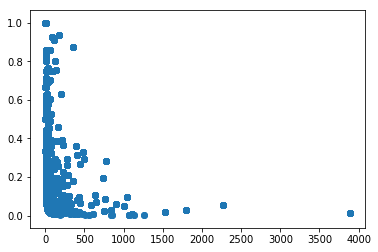

In [84]:
plt.scatter([*map(lambda x: x[2], p_last_name_by_ending)], [*map(lambda x: x[1], p_last_name_by_ending)])

In [85]:
valuable_endings = [*map(lambda x: (x[0], x[1]), filter(lambda x: x[2] > 50 and x[1] > 0.05, p_last_name_by_ending))]
valuable_endings = {key: value for (key, value) in valuable_endings}
train_data['ending3'] = [valuable_endings[name[-3:]]  if name[-3:] in valuable_endings else 0 for name in train_data['name']]

In [86]:
test_data['ending3'] = [valuable_endings[s[-3:]] if s[-3:] in valuable_endings else 0 for s in test_data[0]]

In [87]:
common_endings2_for_last_name = [x[-2:] for (x, y) in zip(train_data['name'], train_data['Y']) if len(x) > 5 and y == 1]

In [88]:
c1 = Counter(common_endings2_for_last_name)
c2 = Counter([x[-2:] for (x, y) in zip(train_data['name'], train_data['Y']) if x[-2:] in common_endings2_for_last_name])
p_last_name_by_ending2 = [(ending, (c1[ending] / c2[ending]), c2[ending]) for ending in common_endings2_for_last_name]

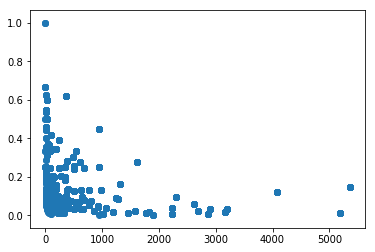

In [89]:
plt.scatter([*map(lambda x: x[2], p_last_name_by_ending2)], [*map(lambda x: x[1], p_last_name_by_ending2)])

In [90]:
valuable_endings2 = [*map(lambda x: (x[0], x[1]), filter(lambda x: x[2] > 50 and x[1] > 0.05, p_last_name_by_ending2))]
valuable_endings2 = {key: value for (key, value) in valuable_endings2}
train_data['ending2'] = [valuable_endings2[name[-2:]]  if name[-2:] in valuable_endings2 else 0 for name in train_data['name']]

In [91]:
test_data['ending2'] = [valuable_endings2[s[-2:]] if s[-2:] in valuable_endings2 else 0 for s in test_data[0]]

Длины

(array([   39.,   962.,  3193.,  2078.,  3010.,  1058.,   168.,   108.,
           15.,     7.]),
 array([  1. ,   2.7,   4.4,   6.1,   7.8,   9.5,  11.2,  12.9,  14.6,
         16.3,  18. ]),
 <a list of 10 Patch objects>)

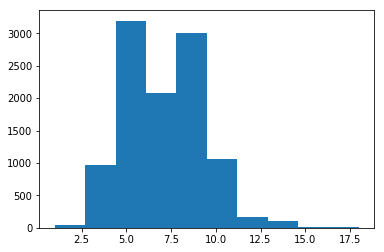

In [110]:
lens_1 = [*(map(lambda x: len(x), train_data[train_data['Y'] == 1]['name']))]
plt.hist(lens_1)

(array([  4.65900000e+03,   3.10240000e+04,   3.34940000e+04,
          1.59930000e+04,   4.60100000e+03,   9.46000000e+02,
          4.70000000e+01,   4.00000000e+00,   0.00000000e+00,
          2.00000000e+00]),
 array([  1. ,   4.2,   7.4,  10.6,  13.8,  17. ,  20.2,  23.4,  26.6,
         29.8,  33. ]),
 <a list of 10 Patch objects>)

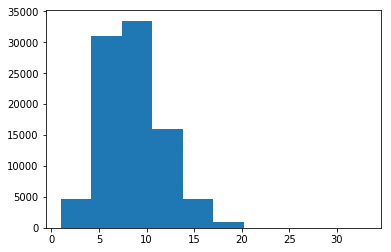

In [109]:
lens_0 = [*(map(lambda x: len(x), train_data[train_data['Y'] == 0]['name']))]
plt.hist(lens_0)

(array([ 0.00215653,  0.05319443,  0.17655906,  0.11490439,  0.16643995,
         0.05850281,  0.00928967,  0.00597193,  0.00082943,  0.00038707]),
 array([  1. ,   2.7,   4.4,   6.1,   7.8,   9.5,  11.2,  12.9,  14.6,
         16.3,  18. ]),
 <a list of 10 Patch objects>)

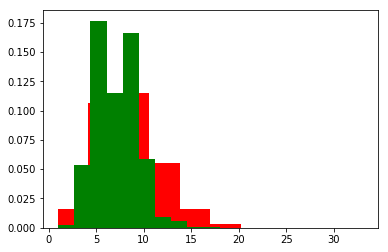

In [114]:
plt.hist(lens_0, normed=True, color='red')
plt.hist(lens_1, normed=True, color='green')

In [115]:
train_data['len'] = [len(s) for s in train_data['name']]
test_data['len'] = [len(s) for s in test_data[0]]

In [116]:
X = train_data[['correct_capitalisation', 'ending3', 'ending2', 'pymorphy', 'len']]
Y = train_data['Y']

In [121]:
estimator = LogisticRegression(penalty='l2',
                               dual=False,
                               tol=0.0001,
                               C=1,
                               fit_intercept=True,
                               intercept_scaling=1,
                               random_state=42,
                               solver='liblinear',
                               max_iter=500,
                               multi_class='ovr',
                               verbose=0,
                               warm_start=False,
                               n_jobs=1)

In [122]:
cross_val_score(estimator, X=X, y=Y, scoring='roc_auc')

array([ 0.88674373,  0.86920193,  0.84673927])

In [123]:
estimator.fit(X[:50000], Y[:50000])

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [124]:
pr = estimator.predict_proba(X[50000:])

In [125]:
roc_auc_score(Y[50000:], pr[:, 1])

0.84869481599517682

In [127]:
estimator = LogisticRegression(penalty='l2',
                               dual=False,
                               tol=0.0001,
                               C=1,
                               fit_intercept=True,
                               intercept_scaling=1,
                               random_state=42,
                               solver='liblinear',
                               max_iter=500,
                               multi_class='ovr',
                               verbose=0,
                               warm_start=False,
                               n_jobs=1)

In [128]:
estimator.fit(X, Y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [129]:
X_test = test_data[['correct_capitalisation', 'ending3', 'ending2', 'pymorphy', 'len']]

In [130]:
ans = pd.read_csv('linear_ans_example.txt')

In [132]:
len(ans['Answer']), len(estimator.predict(X_test))

(188920, 188920)

In [133]:
ans['Answer'] = estimator.predict_proba(X_test)

In [134]:
ans.to_csv("ans_v1.tsv", sep=',', index=False)  # final solution

Без pymorphy:

In [190]:
X = train_data[['correct_capitalisation', 'ending3', 'ending2', 'len']]
Y = train_data['Y']
estimator = LogisticRegression(penalty='l2',
                               dual=False,
                               tol=0.0001,
                               C=1,
                               fit_intercept=True,
                               intercept_scaling=1,
                               random_state=42,
                               solver='liblinear',
                               max_iter=500,
                               multi_class='ovr',
                               verbose=0,
                               warm_start=False,
                               n_jobs=1)
estimator.fit(X, Y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [191]:
X_test = test_data[['correct_capitalisation', 'ending3', 'ending2', 'len']]

In [192]:
ans = pd.read_csv('linear_ans_example.txt')

In [193]:
ans['Answer'] = estimator.predict_proba(X_test)

In [194]:
ans.to_csv("ans_no_pm.tsv", sep=',', index=False)  # final solution

В первом способе есть зависимость при кросс-валидации. Попробую сделать по-другому, через n-grammы

In [162]:
from nltk import ngrams
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer

In [181]:
estimator = LogisticRegression(penalty='l1',
                               dual=False,
                               tol=0.0001,
                               C=1,
                               fit_intercept=True,
                               intercept_scaling=1,
                               random_state=42,
                               solver='liblinear',
                               max_iter=500,
                               multi_class='ovr',
                               verbose=0,
                               warm_start=False,
                               n_jobs=1)

In [184]:
ngram_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(2, 3), min_df=1)

In [185]:
pipeline = make_pipeline(ngram_vectorizer, TfidfTransformer(), estimator)
arr = cross_val_score(pipeline, train_data['name'], train_data['Y'], cv=3, scoring='roc_auc')
print(arr)
print(np.mean(arr))

[ 0.64657664  0.6334594   0.82899272]
0.703009586082


In [155]:
process_ngrams('Йкунеиан')

[('й', 'к'),
 ('к', 'у'),
 ('у', 'н'),
 ('н', 'е'),
 ('е', 'и'),
 ('и', 'а'),
 ('а', 'н'),
 ('й', 'к', 'у'),
 ('к', 'у', 'н'),
 ('у', 'н', 'е'),
 ('н', 'е', 'и'),
 ('е', 'и', 'а'),
 ('и', 'а', 'н'),
 ('й', 'к', 'у', 'н'),
 ('к', 'у', 'н', 'е'),
 ('у', 'н', 'е', 'и'),
 ('н', 'е', 'и', 'а'),
 ('е', 'и', 'а', 'н')]

## TODO: (maybe)